# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing, model_selection
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, GlobalAveragePooling1D, Dense, Activation, Dropout, BatchNormalization, ReLU 
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the Data

In [12]:
df=pd.read_csv('EEG_data.csv')
data = pd.read_csv('demographic_info.csv')

In [13]:
data = data.rename(columns = {'subject ID': 'SubjectID'})
df = df.merge(data,how = 'inner',on = 'SubjectID')
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [14]:
Data = df.copy()

In [15]:
Data.pop('SubjectID')
Data.pop('VideoID')
Data.pop('predefinedlabel')
Data.pop('user-definedlabeln')
Data.pop(' age')
Data.pop(' ethnicity')
Data.pop(' gender')
Data

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0
1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0
2,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0
3,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0
4,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0
...,...,...,...,...,...,...,...,...,...,...,...
12806,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0
12807,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0
12808,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0
12809,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0


Normalizing

In [16]:
Data["Attention"] = Data["Attention"] / Data["Attention"].abs().max()
Data["Mediation"] = Data["Mediation"] / Data["Mediation"].abs().max()
Data["Raw"] = Data["Raw"] / Data["Raw"].abs().max()

In [55]:
x = np.array(Data)
y = np.array(df['user-definedlabeln'])

Splitting

In [56]:
x_train = x[:10000, :]
y_train = y[:10000]
x_val = x[10000:11405, :]
y_val = y[10000:11405]
x_test = x[11405:, :]
y_test = y[11405:]

# Implementing the Network and Training

In [58]:
model = Sequential()
model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Dense(128, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Dense(256, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Dense(512, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.4))
model.add(Dense(256, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Dense(128, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(1, activation="sigmoid"))

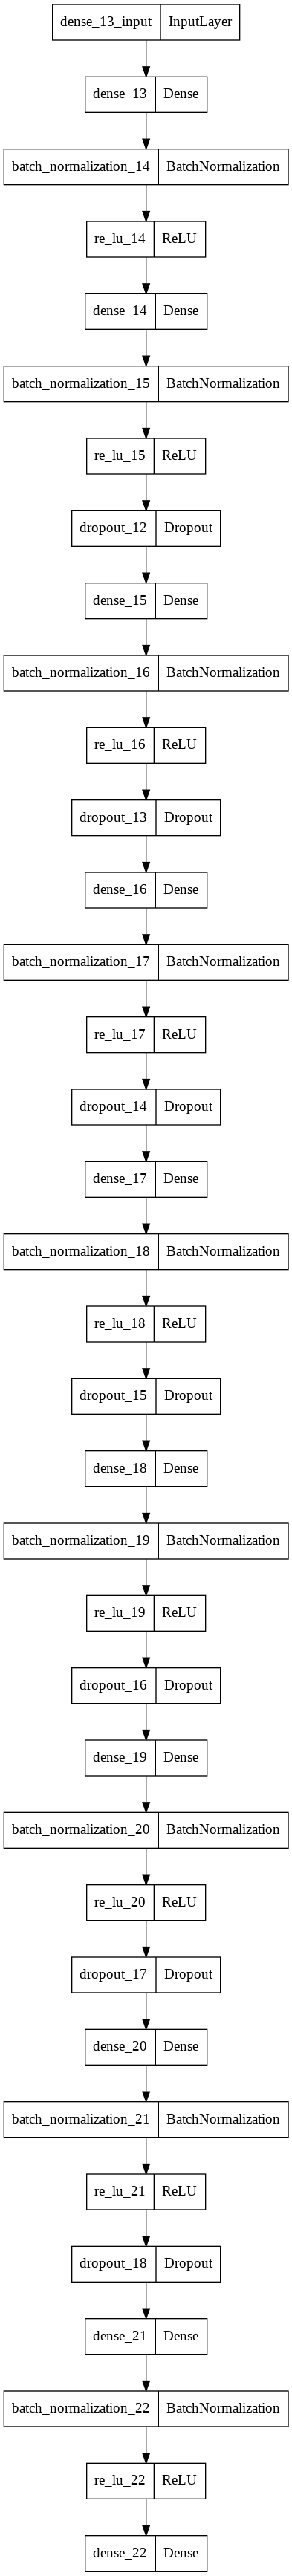

In [65]:
tf.keras.utils.plot_model(model)

In [47]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 4))

In [61]:
model.compile(optimizer=SGD(learning_rate=1e-8, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])

First we will find the optimal Learning Rate

In [62]:
history = model.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
313/313 [==============================] - 5s 10ms/step - loss: 1.0112 - accuracy: 0.4631 - lr: 1.0000e-08
Epoch 2/25
313/313 [==============================] - 3s 9ms/step - loss: 1.0225 - accuracy: 0.4632 - lr: 1.7783e-08
Epoch 3/25
313/313 [==============================] - 3s 10ms/step - loss: 1.0070 - accuracy: 0.4620 - lr: 3.1623e-08
Epoch 4/25
313/313 [==============================] - 3s 9ms/step - loss: 0.9975 - accuracy: 0.4636 - lr: 5.6234e-08
Epoch 5/25
313/313 [==============================] - 3s 10ms/step - loss: 0.9968 - accuracy: 0.4591 - lr: 1.0000e-07
Epoch 6/25
313/313 [==============================] - 3s 10ms/step - loss: 1.0126 - accuracy: 0.4654 - lr: 1.7783e-07
Epoch 7/25
313/313 [==============================] - 3s 9ms/step - loss: 1.0129 - accuracy: 0.4602 - lr: 3.1623e-07
Epoch 8/25
313/313 [==============================] - 3s 9ms/step - loss: 1.0035 - accuracy: 0.4615 - lr: 5.6234e-07
Epoch 9/25
313/313 [==============================] - 3s 10m

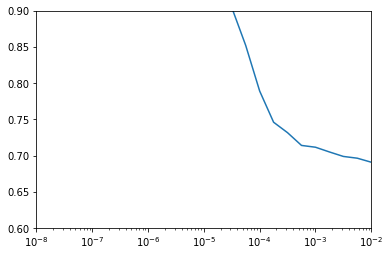

In [64]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 0.01, 0.6, 0.9])
plt.show()

In [66]:
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])

In [67]:
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val,y_val))

Epoch 1/100
313/313 [==============================] - 6s 11ms/step - loss: 0.6884 - accuracy: 0.5749 - val_loss: 0.6877 - val_accuracy: 0.6384
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6903 - accuracy: 0.5747 - val_loss: 0.6917 - val_accuracy: 0.6242
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6862 - accuracy: 0.5867 - val_loss: 0.6940 - val_accuracy: 0.6235
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6853 - accuracy: 0.5819 - val_loss: 0.6870 - val_accuracy: 0.6221
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6850 - accuracy: 0.5803 - val_loss: 0.6895 - val_accuracy: 0.6221
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6837 - accuracy: 0.5858 - val_loss: 0.6834 - val_accuracy: 0.6228
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6843 - accuracy: 0.5829 - val_loss: 0.6927 - val_accuracy:

We will train more

In [71]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-11 * 10**(epoch / 4))
model.compile(optimizer=SGD(learning_rate=1e-11, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history2 = model.fit(x_train, y_train, batch_size=32, epochs=25, callbacks=[lr_schedule])

Epoch 1/25
313/313 [==============================] - 6s 9ms/step - loss: 0.6805 - accuracy: 0.5892 - lr: 1.0000e-11
Epoch 2/25
313/313 [==============================] - 3s 10ms/step - loss: 0.6771 - accuracy: 0.5982 - lr: 1.7783e-11
Epoch 3/25
313/313 [==============================] - 3s 9ms/step - loss: 0.6794 - accuracy: 0.5926 - lr: 3.1623e-11
Epoch 4/25
313/313 [==============================] - 3s 10ms/step - loss: 0.6781 - accuracy: 0.5955 - lr: 5.6234e-11
Epoch 5/25
313/313 [==============================] - 3s 10ms/step - loss: 0.6794 - accuracy: 0.5940 - lr: 1.0000e-10
Epoch 6/25
313/313 [==============================] - 3s 9ms/step - loss: 0.6785 - accuracy: 0.5959 - lr: 1.7783e-10
Epoch 7/25
313/313 [==============================] - 3s 9ms/step - loss: 0.6791 - accuracy: 0.5951 - lr: 3.1623e-10
Epoch 8/25
313/313 [==============================] - 3s 10ms/step - loss: 0.6796 - accuracy: 0.5956 - lr: 5.6234e-10
Epoch 9/25
313/313 [==============================] - 3s 10m

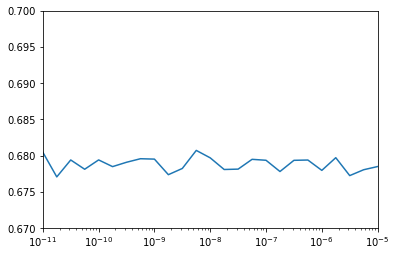

In [73]:
plt.semilogx(history2.history["lr"], history2.history["loss"])
plt.axis([1e-11, 1e-5, 0.67, 0.7])
plt.show()

In [75]:
model.compile(optimizer=SGD(learning_rate=9e-8, momentum=0.9), loss=['binary_crossentropy'], metrics=['accuracy'])
history2 = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=val)

Epoch 1/100
313/313 [==============================] - 6s 11ms/step - loss: 0.6782 - accuracy: 0.5997 - val_loss: 0.7079 - val_accuracy: 0.5957
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6790 - accuracy: 0.5936 - val_loss: 0.7071 - val_accuracy: 0.5972
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6804 - accuracy: 0.5925 - val_loss: 0.7080 - val_accuracy: 0.5950
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6791 - accuracy: 0.5957 - val_loss: 0.7061 - val_accuracy: 0.6014
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6766 - accuracy: 0.5968 - val_loss: 0.7066 - val_accuracy: 0.6000
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6791 - accuracy: 0.5997 - val_loss: 0.7102 - val_accuracy: 0.5886
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6798 - accuracy: 0.5925 - val_loss: 0.7083 - val_accuracy:

# Evaluation

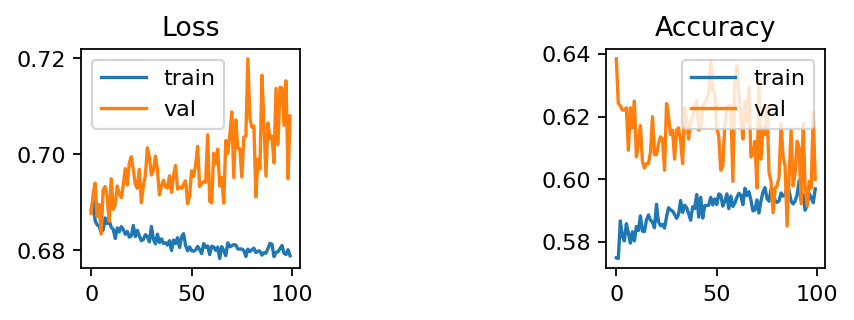

In [70]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

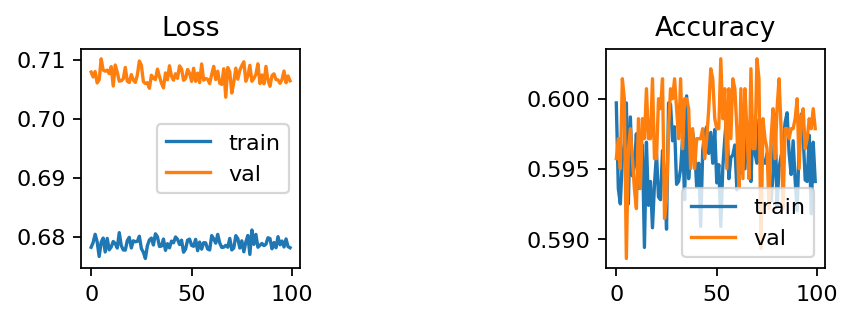

In [76]:
plt.figure( dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [78]:
y_hat = model.predict(test)

44/44 [==============================] - 0s 3ms/step


In [79]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.5533428165007113
Accuracy:  0.5533428165007113
Precision:  0.5533428165007113
Recall:  0.5533428165007113
Confusion Matrix: 



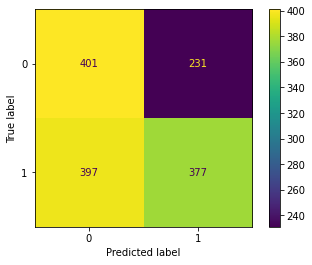

In [80]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()